In [58]:
# initial setup
%run "../../../common/0_notebooks_base_setup.py"


/Users/csuarezgurruchaga/Desktop/Digital-House/CLASE_47/dsad_2021/common
default checking
Running command `conda list`... ok
jupyterlab=2.2.6 already installed
pandas=1.1.5 already installed
bokeh=2.2.3 already installed
seaborn=0.11.0 already installed
matplotlib=3.3.2 already installed
ipywidgets=7.5.1 already installed
pytest=6.2.1 already installed
chardet=4.0.0 already installed
psutil=5.7.2 already installed
scipy=1.5.2 already installed
statsmodels=0.12.1 already installed
scikit-learn=0.23.2 already installed
xlrd=2.0.1 already installed
nltk=3.5 already installed
unidecode=1.1.1 already installed
pydotplus=2.0.2 already installed
pandas-datareader=0.9.0 already installed
flask=1.1.2 already installed


<img src='../../../common/logo_DH.png' align='left' width=35%/>

## Desafío: Clasificación de artículos de diario

Trabajaremos con un dataset de noticias de los diarios Clarin y Pagina12. El objetivo de la práctica será implementar un modelo que permita predecir de qué diario proviene una noticia.

In [59]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,confusion_matrix
import unidecode
from nltk.corpus import stopwords 

### 1. Importamos los datos

* Importen los datos con pandas y generen un dataframe agregando una columna 'clase' que indique si son noticias de Clarin o de Pagina12.

Las noticias de Clarin se encuentran en '../Data/clarin.csv' y las de Pagina12 en '../Data/pagina12.csv'.

* Concatenen ambos data sets en un solo dataframe.

* ¿Cuántas noticias tenemos de cada diario?

* ¿Qué columnas tiene el dataframe? 

In [60]:
clarin = pd.read_csv('../Data/clarin.csv')
pagina = pd.read_csv('../Data/pagina12.csv')

In [61]:
clarin['clase']='clarin'
pagina['clase']='pagina12'

In [62]:
df=pd.concat([clarin, pagina], axis=0)

In [63]:
df.clase.value_counts()

clarin      382
pagina12    221
Name: clase, dtype: int64

In [64]:
df.columns

Index(['Unnamed: 0', 'cuerpo', 'fecha_hora', 'imagen', 'resumen', 'suplemento',
       'titulo', 'url', 'clase'],
      dtype='object')

In [65]:
df.shape[1]

9

### 2. Limpieza

#### 2.1 Faltantes

A partir del dataset observamos que los campos que probablemente contengan el vocabulario relevante son "cuerpo", "título" y "resumen".

* Saquen del análisis los registros que no tienen cuerpo o título disponible

* Completen los resúmenes faltantes con una campo en blanco


In [66]:
df.cuerpo.dropna(inplace = True)
df.titulo.dropna(inplace=True)

In [67]:
df.resumen.fillna(' ', inplace=True)

In [68]:
df.sample(2)

,Unnamed: 0,cuerpo,fecha_hora,imagen,resumen,suplemento,titulo,url,clase
36,36,"Por primera vez en la historia de Uruguay, u...",10/10/2017,//images.clarin.com/2017/10/10/HkdWi_c3W_930x5...,"Michelle Suárez, de 33 años, milita en el Part...",/sociedad/,Asumió la primera senadora trans en Uruguay,http://www.clarin.com/sociedad/asumio-primera-...,clarin
33,33,México y Costa Rica lograron la clasificación ...,09 de octubre de 2017,NaN,,NaN,Arde la Concacaf,https://www.pagina12.com.ar/67921-arde-la-conc...,pagina12


#### 2.2 Suplementos relevantes

Para mejorar la clasificación es conveniente retirar las secciones donde los dos diarios utilizan un vocabulario similar y muy específico del dominio como, por ejemplo, las relacionadas a deportes.

* Miren las secciones dentro de la columna 'suplemento': Ojo que hay secciones de deportes con diferente nombre por ejemplo '/deportes/futbol/'

* Remuevan las noticias de deportes

In [70]:
import regex as re

In [71]:
df = df.applymap(lambda x: x.lower() if type(x)==str else x)

In [76]:
deporte=re.compile('deporte')

deporte_row=df['suplemento'].apply(lambda x : re.match(deporte, str(x)))

strip_rows_mask=deporte_row.isnull()

df = df[strip_rows_mask]

df.drop(index=df[df['suplemento']=='/br/'].index,inplace=True) # Tiro articulos en portugues

#### 2.3 Corpus

El data set tiene informacion relevante en las columnas 'título', 'resumen' y 'cuerpo', de modo que podemos generar una nueva columna que sea la concatenación de estas tres. 

* Generen dicha columna, que será nuestro corpus de documentos.


In [77]:
df ['corpus']=df['titulo'] + ' ' +df['resumen'] + ' ' + df['cuerpo']

In [79]:
df.head(2)

,Unnamed: 0,cuerpo,fecha_hora,imagen,resumen,suplemento,titulo,url,clase,corpus
0,0,"el ministerio de agroindustria de la nación,...",10/10/2017,//images.clarin.com/2017/10/10/sj21dsq3z_930x5...,de acuerdo a los datos relevados por el instit...,/lo-ultimo/,soja: aumentó la superficie sembrada con semil...,http://www.clarin.com/rural/soja-aumento-siemb...,clarin,soja: aumentó la superficie sembrada con semil...
1,1,"políticos, economistas, funcionarios, empres...",10/10/2017,//images.clarin.com/2017/10/10/hj7cmic3z_930x5...,los sondeos para las próximas elecciones y la ...,/lo-ultimo/,"políticos, empresarios y periodistas en la cel...",http://www.clarin.com/politica/politicos-empre...,clarin,"políticos, empresarios y periodistas en la cel..."


## 3. Modelo

### 3.1 

* Vectoricen el corpus de textos resultante con CountVectorizer, removiendo stopwords. Usen el argumento strip_accents='unicode' para remover tildes del texto.

Atención: las stopwords importadas de nltk contienen tildes. Elimínenlas antes de vectorizar el corpus.

* ¿Cuál es la dimensión de la matriz de features?

* Apliquen un modelo Naive Bayes con un split simple entre train y test. 

* ¿Cuál es el accuracy obtenido?  

* Dibujen la matriz de confusión.

In [103]:
from nltk.corpus import stopwords 
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from nltk.stem.snowball import SnowballStemmer #spanish
from sklearn.model_selection import train_test_split

In [107]:
stop_words = stopwords.words('spanish')
stop_words=[unidecode.unidecode(word.lower()) for word in stop_words ]; # quitamos acentos de las stopwords

spanishStemmer=SnowballStemmer("spanish")

stop_words_estem = [spanishStemmer.stem(_) for _ in stop_words]


df.corpus = df.corpus.apply(lambda x: spanishStemmer.stem(str(x)))

vectorizer=TfidfVectorizer(strip_accents='unicode', stop_words=stop_words_estem)

In [112]:
X_train, X_test, y_train, y_test = train_test_split(df.corpus, df.clase, stratify = df.clase, random_state =1203)

In [113]:
X_train = vectorizer.fit_transform(X_train)
X_test  = vectorizer.transform(X_test)

In [114]:
X_train.shape

(424, 26382)

In [115]:
nb=MultinomialNB().fit(X_train, y_train)

In [116]:
accuracy_score(y_test, nb.predict(X_test))

0.6619718309859155

In [117]:
confusion_matrix(y_test, nb.predict(X_test))

array([[93,  0],
       [48,  1]])

### 3.2 Optimización del modelo

* Hagan una gridsearch cross validation variando el hiperparámetro alpha en el rango (0;0.1)

* Vean la accuracy y la matriz de confusión obtenida con el mejor modelo, en el test set.

In [122]:
np.arange(0.1,1,0.1)

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [127]:
param_grid = {'alpha':np.arange(0.01,1,0.1)}

skf = StratifiedKFold(shuffle = True, random_state=1203)

gs = GridSearchCV(MultinomialNB(), param_grid, cv = skf).fit(X_train, y_train)

best_nb = gs.best_estimator_

In [128]:
accuracy_score(y_test, best_nb.predict(X_test))

0.823943661971831

In [129]:
confusion_matrix(y_test, best_nb.predict(X_test))

array([[89,  4],
       [21, 28]])

### 4. Análisis de los resultados 

El modelo entrenado tiene el atributo "feature_log_prob" que contiene el logaritmo de los coeficientes $\theta_{yi}$, que representan la probabilidad de que el término i-ésimo pertenezca a la clase $y$.

¿Cuáles son las features (palabras) que mejor separan a las dos clases?

* Calculen el cociente entre los logaritmos de los coeficientes estimados para la clase "clarin" y para "pagina12". ¿Cuáles términos mustran mayor diferencia entre ambos valores?

In [155]:
prob_df = pd.DataFrame(np.transpose(best_nb.feature_log_prob_), columns = ['clarin','pagina12'])

prob_df['relative_importance']=best_nb.feature_log_prob_[0]/best_nb.feature_log_prob_[1]
prob_df['prediccion'] = prob_df['relative_importance'].apply(lambda x: 'clarin' if x>1 else 'pagina 12')

prob_df

,clarin,pagina12,relative_importance,prediccion
0,-9.642326,-10.006470,0.963609,pagina 12
1,-8.133229,-8.972816,0.906430,pagina 12
2,-10.704275,-10.621040,1.007837,clarin
3,-10.842437,-10.621040,1.020845,clarin
4,-10.589056,-10.621040,0.996989,pagina 12
...,...,...,...,...
26377,-10.528606,-10.621040,0.991297,pagina 12
26378,-10.971231,-10.074580,1.089001,clarin
26379,-10.456410,-10.621040,0.984500,pagina 12
26380,-10.456410,-10.621040,0.984500,pagina 12


In [131]:
best_nb.feature_log_prob_[0]

array([ -9.64232609,  -8.13322936, -10.7042753 , ..., -10.45640958,
       -10.45640958, -10.45640958])

In [136]:
best_nb.feature_log_prob_[1][:20]

array([-10.00647034,  -8.97281571, -10.62104031, -10.62104031,
       -10.62104031, -10.62104031,  -9.86713593, -10.62104031,
       -10.62104031, -10.62104031, -10.62104031,  -9.9176872 ,
       -10.62104031, -10.04286129, -10.62104031, -10.62104031,
       -10.34455943, -10.62104031, -10.11114898, -10.54506659])

/Users/csuarezgurruchaga/opt/anaconda3/envs/dhdsblend2021/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Términos representativos de Clarín:

['mira' 'cargando' 'video' 'jugadores' 'hamilton' 'leonas' 'messi'
 'hockey' 'bienal' 'pic' 'suar' 'vettel' 'shanghai' 'estrellas' 'cafe'
 'super' 'iphone' 'futbol' 'lionel' 'piloto' 'schwartzman' 'diego'
 'rebotes' 'juegos' 'olimpico' 'evita' 'chicos' 'meolans' 'potro'
 'hinchas' 'lamotta' 'arquitectura' 'ardusso' 'productor' 'clarin' 'liga'
 'seleccion' 'choque' 'esquizofrenia' 'new' 'all' 'mensajes' 'aleman'
 'jugador' 'nba' 'pol' 'ka' 'spataro' 'entradas' 'ferro' 'bossi' 'ap'
 'moto' 'metros' 'apple' 'vehiculo' 'bonelli' 'david' 'harvey' 'carne'
 'papa' 'cristiano' 'duelo' 'sorprendio' 'palermo' 'ecuador' 'estabilidad'
 'sufrio' 'golovkin' 'musica' 'ciccone' 'leones' 'carrera' 'laurita'
 'disponibles' 'campeon' 'edificio' 'medico' 'antonana' 'monk' 'av' 'fifa'
 'bar' 'ronaldo' 'mejores' 'pista' 'lesion' 'fechas' 'participan'
 'marcaron' 'google' 'roger' 'autos' 'nadal' 'tecnologico' 'ferrari' 'pie'
 'open' 'oscar' 'ranking']

Términos representa

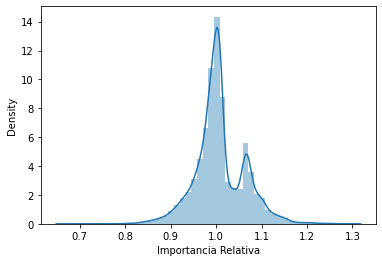

In [156]:
relative_importance=best_nb.feature_log_prob_[0]/best_nb.feature_log_prob_[1];
# Los valores son log-prob (negativos) de modo que relative_importance < 1 implica que
# el coeficiente asignado en la clase 0 (clarin) es mayor que en la clase 1 (pagina) y viceveras
%matplotlib inline
sns.distplot(relative_importance)
plt.xlabel('Importancia Relativa')

features=np.array(vectorizer.get_feature_names());

indices=np.argsort(relative_importance);

print('Términos representativos de Clarín:\n')
print(features[indices[:100]])

print('\nTérminos representativos de Página12:\n')
print(features[indices[-100:]])